In [1]:
import sys
sys.path.append('../code')

In [37]:
import cPickle as pickle
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
from add_model_features import add_features

In [4]:
with open('../data/all_patch_draft_dfs.pkl') as f:
    patch_draft_dfs = pickle.load(f)
del patch_draft_dfs['6.77']

In [5]:
for key, df in patch_draft_dfs.iteritems():
    df = df.copy()
    patch_draft_dfs[key] = add_features(df)
full_df = pd.concat(patch_draft_dfs, keys=None)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [47]:
df_684 = patch_draft_dfs['6.84']

In [48]:
df_684['avg_pred'] = df_684['predictions'].apply(np.mean)

In [49]:
df_684['num_changes'] = df_684['predictions'].apply(np.size)

In [50]:
df_684['predictions'][1]

array([ 0.8069,  0.7242,  0.9359])

In [52]:
num_numeric_changes = []
for i, row in df_684.iterrows():
    num_numeric_changes.append(np.sum(np.array(row['ratios']) >= 0))
df_684['num_numeric_changes'] = num_numeric_changes

In [53]:
avg_ratio = []
for ratio_list in df_684['ratios']:
    ratios = np.array(ratio_list)
    mean_ratio = np.mean(ratios[ratios >= 0])
    if type(mean_ratio) in [float, np.float64] and not np.isnan(mean_ratio):
        avg_ratio.append(np.mean(ratios[ratios >= 0]))
    else:
        avg_ratio.append(1)
df_684['avg_ratio'] = avg_ratio

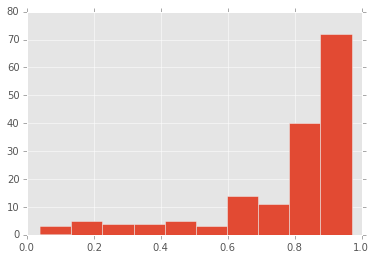

In [54]:
all_preds = []
for item in df_684['predictions']:
    for sub_item in item:
        all_preds.append(sub_item)
_ = plt.hist(all_preds)

In [55]:
num_changes_0_4 = np.zeros(len(df_684))
num_changes_4_6 = np.zeros(len(df_684))
num_changes_6_7 = np.zeros(len(df_684))
num_changes_7_8 = np.zeros(len(df_684))
num_changes_8_9 = np.zeros(len(df_684))
num_changes_9_10 = np.zeros(len(df_684))
for i, pred_list in enumerate(df_684['predictions']):
    for item in pred_list:
        if 0 <= item < 0.4:
            num_changes_0_4[i] += 1
        elif 0.4 <= item < 0.6:
            num_changes_4_6[i] += 1
        elif 0.6 <= item < 0.7:
            num_changes_6_7[i] += 1
        elif 0.7 <= item < 0.8:
            num_changes_7_8[i] += 1
        elif 0.8 <= item < 0.9:
            num_changes_8_9[i] += 1
        elif item >= 0.9:
            num_changes_9_10[i] += 1
        else:
            print 'some item got missed'
df_684['num_changes_0_4'] = num_changes_0_4
df_684['num_changes_4_6'] = num_changes_4_6
df_684['num_changes_6_7'] = num_changes_6_7
df_684['num_changes_7_8'] = num_changes_7_8
df_684['num_changes_8_9'] = num_changes_8_9
df_684['num_changes_9_10'] = num_changes_9_10

In [56]:
pred_dummies = pd.get_dummies(pd.cut(df_684['avg_pred'], [0, 0.4, 0.6, 0.7, 0.8, 0.9, 1.01]), prefix='avg_pred', dummy_na=True)
df_684 = pd.concat([df_684, pred_dummies], axis=1)

In [57]:
composite_ally_change = np.zeros(len(df_684))
composite_counter_change = np.zeros(len(df_684))
for i, row in df_684.iterrows():
    allies = row['prev_patch_allies']
    counters = row['prev_patch_counters']
    for ally in allies:
        ally_pred = df_684[df_684['hero']==ally[0]]['avg_pred'].values[0]
        if ally[1] > 0 and not np.isnan(ally_pred):
            composite_ally_change[i] += ally[1] * ally_pred
    for counter in counters:
        counter_pred = df_684[df_684['hero']==counter[0]]['avg_pred'].values[0]
        if not np.isnan(counter_pred):
            composite_counter_change[i] += counter[1] * counter_pred

df_684['composite_ally_change'] = composite_ally_change
df_684['composite_counter_change'] = composite_counter_change

In [58]:
df_684.head(4).T

,0,1,2,3
hero,Abaddon,Alchemist,Ancient Apparition,Anti-Mage
patch,6.84,6.84,6.84,6.84
text,[Borrowed Time can now be cast while disabled ...,[Unstable Concoction:\n\n Countdown can now be...,[Chilling Touch buff can now be removed by cli...,[]
text_no_abi,[can now be cast while disabled (same rules as...,[:\n\n Countdown can now be seen by enemies\n\...,[buff can now be removed by clicking on the bu...,[]
predictions,[0.921],"[0.8069, 0.7242, 0.9359]",[0.6837],[]
ratios,[None],"[None, None, None]",[None],[]
pick%,1.6,1.2,9.9,9.5
ban%,0.6,0.3,15.1,14.7
pb%,2.2,1.4,25,24.2
times_pb,34,22,391,378


In [59]:
df_test = df_684.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)

df_test['prev_patch_pb%'].fillna(0, inplace=True)
df_test['prev_patch_winrate'].fillna(0, inplace=True)

In [60]:
target = df_test.pop('pb%').values

In [61]:
X = df_test.values

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [64]:
mean_squared_error(target, rf.predict(X))

58.562912499999953

In [65]:
mean_squared_error(target, df_test['prev_patch_pb%'])

636.64851851851859

In [74]:
X_train, X_test, y_train, y_test, prev_train, prev_test = train_test_split(X, target, df_test['prev_patch_pb%'].values, random_state=0)

In [75]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [76]:
mean_squared_error(y_test, rf.predict(X_test))

366.12833203703713

In [77]:
mean_squared_error(y_test, prev_test)

485.72629629629625

In [78]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
mean_squared_error(y_test, gbr.predict(X_test))

559.02705517942172

In [79]:
min_val = 0
min_mse = float('inf')
for const in np.linspace(0, 100, num=1000):
    if mean_squared_error(y_test, [const]*len(y_test)) < min_mse:
        min_val = const
        min_mse = mean_squared_error(y_test, [const]*len(y_test))

In [80]:
min_mse

393.61410524638762

In [103]:
df_test = full_df.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)
df_test['prev_patch_pb%'].fillna(0, inplace=True)
df_test['prev_patch_winrate'].fillna(0, inplace=True)

In [104]:
target = df_test.pop('pb%').values

In [105]:
X = df_test.values

In [106]:
sum(np.isnan(X))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [107]:
sum(np.isinf(X))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [108]:
X_train, X_test, y_train, y_test, prev_train, prev_test = train_test_split(X, target, df_test['prev_patch_pb%'].values, random_state=0)

In [109]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [117]:
mean_squared_error(y_test[y_test>50], rf.predict(X_test[y_test>50]))

1439.0450355970875

In [118]:
mean_squared_error(y_test[y_test>50], prev_test[y_test>50])

1326.4490000000003

In [110]:
mean_squared_error(y_test, rf.predict(X_test))

386.66237973540717

In [111]:
mean_squared_error(y_test, prev_test)

409.25851063829782

In [17]:
min_val = 0
min_mse = float('inf')
for const in np.linspace(0, 100, num=1000):
    if mean_squared_error(y_test, [const]*len(y_test)) < min_mse:
        min_val = const
        min_mse = mean_squared_error(y_test, [const]*len(y_test))

In [18]:
min_mse

496.62189136108611

In [19]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
mean_squared_error(y_test, gbr.predict(X_test))

393.93970939006778

In [32]:
full_50_pbr = full_df[full_df['pb%'] > 50]
df_test = full_50_pbr.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)
df_test['prev_patch_pb%'].fillna(0, inplace=True)
df_test['prev_patch_winrate'].fillna(0, inplace=True)
target = df_test.pop('pb%').values
X = df_test.values
X_train, X_test, y_train, y_test, prev_train, prev_test = train_test_split(X, target, df_test['prev_patch_pb%'].values, random_state=0)
mean_squared_error(y_test, prev_test)

1775.9359259259259

In [25]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

223.52739766666662

In [26]:
np.argsort(rf.feature_importances_)[::-1]

array([ 1,  0, 18,  4, 19,  3,  2, 10, 13,  5, 12, 16,  7,  9, 17, 15,  8,
       11, 14,  6])

In [27]:
rf.feature_importances_

array([ 0.20937991,  0.2776114 ,  0.02892706,  0.03147612,  0.09887913,
        0.01657886,  0.00200939,  0.01169385,  0.00935406,  0.01132311,
        0.0223219 ,  0.00901818,  0.01429229,  0.0207023 ,  0.0036592 ,
        0.00944983,  0.01411839,  0.01041966,  0.1112362 ,  0.08754917])

In [28]:
df_test.columns[np.argsort(rf.feature_importances_)[::-1]]

Index([u'prev_patch_winrate', u'prev_patch_pb%', u'composite_ally_change',
       u'avg_ratio', u'composite_counter_change', u'num_numeric_changes',
       u'num_changes', u'num_changes_9_10', u'avg_pred_(0.6, 0.7]',
       u'num_changes_0_4', u'avg_pred_(0.4, 0.6]', u'avg_pred_(0.9, 1.01]',
       u'num_changes_6_7', u'num_changes_8_9', u'avg_pred_nan',
       u'avg_pred_(0.8, 0.9]', u'num_changes_7_8', u'avg_pred_(0, 0.4]',
       u'avg_pred_(0.7, 0.8]', u'num_changes_4_6'],
      dtype='object')

In [29]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
mean_squared_error(y_test, gbr.predict(X_test))

242.80731618447172

In [31]:
df_test.columns[np.argsort(gbr.feature_importances_)[::-1]]

Index([u'composite_counter_change', u'prev_patch_winrate', u'prev_patch_pb%',
       u'composite_ally_change', u'avg_ratio', u'num_numeric_changes',
       u'num_changes', u'num_changes_6_7', u'num_changes_8_9',
       u'num_changes_0_4', u'num_changes_9_10', u'avg_pred_(0.6, 0.7]',
       u'avg_pred_(0.8, 0.9]', u'avg_pred_(0.4, 0.6]', u'avg_pred_(0.9, 1.01]',
       u'avg_pred_nan', u'avg_pred_(0, 0.4]', u'num_changes_7_8',
       u'avg_pred_(0.7, 0.8]', u'num_changes_4_6'],
      dtype='object')

In [96]:
len(full_df)

939

In [64]:
full_50_old_pbr = full_df[full_df['prev_patch_pb%'] > 50]
df_test = full_50_old_pbr.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)
df_test['prev_patch_pb%'].fillna(0, inplace=True)
df_test['prev_patch_winrate'].fillna(0, inplace=True)
target = df_test.pop('pb%').values
X = df_test.values
X_train, X_test, y_train, y_test, prev_train, prev_test = train_test_split(X, target, df_test['prev_patch_pb%'].values, random_state=0)
mean_squared_error(y_test, prev_test)

1195.7710714285713

In [65]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

584.14243707142873

In [66]:
rf_grid = {'max_depth': [3, None],
           'max_features': [1, 3, 10],
           'min_samples_split': [1, 3, 10],
           'min_samples_leaf': [1, 3, 10],
           'bootstrap': [True, False],
           'n_estimators': [75, 100, 125],
           'random_state': [0]}

In [41]:
rf_grid = GridSearchCV(RandomForestRegressor(), rf_grid, n_jobs=-1, verbose=True, scoring='mean_squared_error').fit(X_train, y_train)
rf_grid.best_params_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 966 out of 972 | elapsed:   28.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   28.1s finished


In [67]:
rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_split=1, min_samples_leaf=10, max_features=10, bootstrap=False, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

535.91623700170578

In [68]:
rf.predict(X_test)

array([ 45.25120575,  60.28464549,  38.62805973,  56.22536897,
        38.31459701,  46.9041385 ,  34.83471453,  46.27998374,
        38.28716123,  39.53884425,  42.2724415 ,  39.43804038,
        38.37839499,  39.43343791,  39.40273358,  33.74044467,
        60.05181088,  52.69691315,  59.35341293,  44.30998547,
        38.81661048,  45.56271274,  58.30354386,  38.66006502,
        42.70185476,  39.17390369,  41.73207721,  51.21052615])

In [69]:
y_test

array([ 87.9,  63.4,  41.4,  40.4,  87.4,  16.1,   5.8,  63.2,  57.1,
        42.9,  33.2,  54.1,  33.8,  69.5,   1.8,  36.4,  21. ,  62.8,
        57.6,  25.2,  40.9,  22.1,  66. ,  66.9,  70. ,  27. ,  26.4,  81. ])

In [70]:
prev_test

array([ 82.8,  91.9,  58.5,  93.6,  68.5,  90.3,  76.3,  71. ,  54.1,
        66. ,  64. ,  66.1,  57.7,  76.9,  58.7,  59.1,  86.7,  57.1,
        89.3,  53.5,  53.3,  51.1,  88.8,  55.6,  50.9,  76.2,  71. ,  74.6])

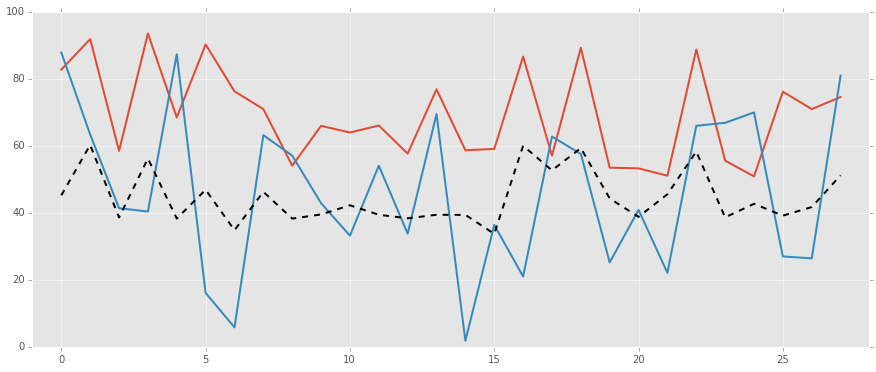

In [102]:
plt.figure(figsize=(15, 6))
plt.xlim(-1, len(prev_test))
plt.plot(range(len(prev_test)), prev_test, linewidth=2)
plt.plot(range(len(prev_test)), y_test, linewidth=2)
plt.plot(range(len(prev_test)), rf.predict(X_test), '--', linewidth=2, color='black')


In [55]:
full_50_pbr = full_df[full_df['pb%'] > 50]
df_test = full_50_pbr.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)
df_test['prev_patch_pb%'].fillna(0, inplace=True)
df_test['prev_patch_winrate'].fillna(0, inplace=True)
target = df_test.pop('pb%').values
X = df_test.values
X_train, X_test, y_train, y_test, prev_train, prev_test = train_test_split(X, target, df_test['prev_patch_pb%'].values, random_state=0)
mean_squared_error(y_test, prev_test)

1775.9359259259259

In [57]:
rf_grid = GridSearchCV(RandomForestRegressor(), rf_grid, n_jobs=-1, verbose=True, scoring='mean_squared_error').fit(X_train, y_train)
rf_grid.best_params_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 966 out of 972 | elapsed:   28.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   29.1s finished


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 10,
 'min_samples_split': 1,
 'n_estimators': 125,
 'random_state': 0}

In [58]:
rf = RandomForestRegressor(n_estimators=125, max_depth=3, min_samples_split=1, min_samples_leaf=10, max_features=1, bootstrap=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

172.76590610262497

In [146]:
# this looks good but is unfortunately cheating

In [119]:
for key, df in patch_draft_dfs.iteritems():
    df = df.copy()
    patch_draft_dfs[key] = add_features(df)
df_686 = patch_draft_dfs.pop('6.86')
df_no_686 = pd.concat(patch_draft_dfs, keys=None)

In [150]:
df_train = df_no_686.copy()
df_train.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)
df_train['prev_patch_pb%'] = df_test['prev_patch_pb%'].fillna(0)
df_train['prev_patch_winrate'] = df_test['prev_patch_winrate'].fillna(0)
y_train = df_train.pop('pb%').values
X_train = df_train.values

In [152]:
df_test = df_686.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)
df_test['prev_patch_pb%'] = df_test['prev_patch_pb%'].fillna(0)
df_test['prev_patch_winrate'] = df_test['prev_patch_winrate'].fillna(0)
y_test = df_test.pop('pb%').values
X_test = df_test.values

In [153]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

247.06583265945136

In [154]:
mean_squared_error(y_test, df_test['prev_patch_pb%'].values)

275.51773584905652

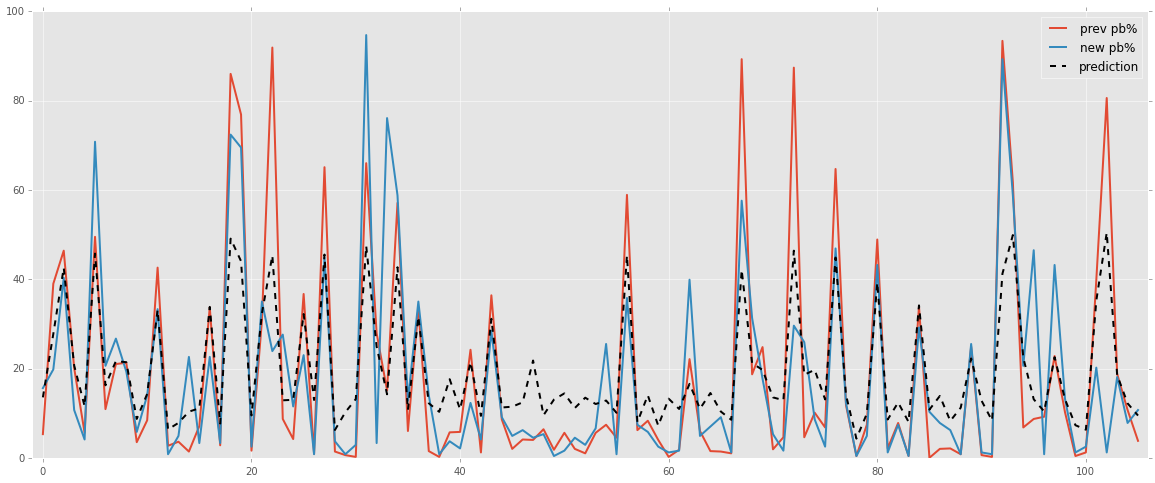

In [166]:
plt.figure(figsize=(20, 8))
plt.xlim(-1, len(y_test))
plt.plot(range(len(y_test)), df_test['prev_patch_pb%'].values, linewidth=2, label="prev pb%")
plt.plot(range(len(y_test)), y_test, linewidth=2, label='new pb%')
plt.plot(range(len(y_test)), rf.predict(X_test), '--', linewidth=2, color='black', label='prediction')
plt.legend()

In [163]:
rf_grid = {'max_depth': [3, None],
           'max_features': [5, 7, 10, 12],
           'min_samples_split': [1, 2, 5],
           'min_samples_leaf': [5, 7, 10, 12],
           'bootstrap': [True, False],
           'n_estimators': [50, 75, 100],
           'random_state': [0]}
rf_opt = GridSearchCV(RandomForestRegressor(), rf_grid, n_jobs=-1, verbose=True, scoring='mean_squared_error').fit(X_train, y_train)
rf_opt.best_params_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 966 out of 972 | elapsed:   44.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   44.5s finished


{'bootstrap': True,
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 1,
 'n_estimators': 75,
 'random_state': 0}

In [164]:
rf = RandomForestRegressor(n_estimators=75, min_samples_split=1, min_samples_leaf=10, max_features=10, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

204.29697437253068